In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams as rcP

%matplotlib inline

In [2]:
# Loading the dataset
df=pd.read_csv("C:/Users/Admin/Desktop/Bengaluru_House_Data/Bengaluru_House_Data.csv")

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
# Exploring the dataset
df.shape

(13320, 9)

In [5]:
#Exploring the datset
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [6]:
df.groupby('size')['size'].agg('count')

size
1 BHK          538
1 Bedroom      105
1 RK            13
10 BHK           2
10 Bedroom      12
11 BHK           2
11 Bedroom       2
12 Bedroom       1
13 BHK           1
14 BHK           1
16 BHK           1
18 Bedroom       1
19 BHK           1
2 BHK         5199
2 Bedroom      329
27 BHK           1
3 BHK         4310
3 Bedroom      547
4 BHK          591
4 Bedroom      826
43 Bedroom       1
5 BHK           59
5 Bedroom      297
6 BHK           30
6 Bedroom      191
7 BHK           17
7 Bedroom       83
8 BHK            5
8 Bedroom       84
9 BHK            8
9 Bedroom       46
Name: size, dtype: int64

In [7]:
df.groupby('availability')['availability'].agg('count')

availability
14-Jul                      1
14-Nov                      1
15-Aug                      1
15-Dec                      1
15-Jun                      1
15-Nov                      2
15-Oct                      2
16-Dec                      4
16-Jan                      1
16-Jul                      1
16-Mar                      3
16-Nov                      1
16-Oct                      1
16-Sep                      2
17-Apr                      7
17-Aug                      9
17-Dec                     29
17-Feb                      2
17-Jan                      1
17-Jul                     12
17-Jun                     13
17-Mar                      5
17-May                      8
17-Nov                     12
17-Oct                     21
17-Sep                     11
18-Apr                    271
18-Aug                    200
18-Dec                    307
18-Feb                     62
                        ...  
20-Aug                     16
20-Dec                     

In [8]:
df=df.drop('society',axis='columns')
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


## Data cleaning Process

In [9]:
#checking the null values in dataset
df.isnull().sum()

area_type         0
availability      0
location          1
size             16
total_sqft        0
bath             73
balcony         609
price             0
dtype: int64

In [10]:
# Applying median to the balcony and bath column
from math import floor
balcony_median=float(floor(df.balcony.median()))
bath_median=float(floor(df.bath.median()))

df.balcony=df.balcony.fillna(balcony_median)
df.bath=df.bath.fillna(bath_median)

In [11]:
df.isnull().sum()

area_type        0
availability     0
location         1
size            16
total_sqft       0
bath             0
balcony          0
price            0
dtype: int64

In [12]:
# Dropping the rows with null values because the dataset is huge as compared to null values.
df=df.dropna()

In [13]:
df.isnull().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [14]:
df.shape

(13303, 8)

In [15]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [16]:
df['bhk']=df['size'].apply(lambda x:int(x.split(' ')[0]))
df=df.drop('size',axis='columns')
df.head()

,area_type,availability,location,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,1056,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,2600,5.0,3.0,120.00,4
2,Built-up Area,Ready To Move,Uttarahalli,1440,2.0,3.0,62.00,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,1521,3.0,1.0,95.00,3
4,Super built-up Area,Ready To Move,Kothanur,1200,2.0,1.0,51.00,2


In [17]:
# Exploring the total_sqft column
df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [18]:
# Since the total_sqft contains range values such as 1133-1384, lets filter out these values
def isFloat(x):
    try:
        float(x)
    except:
        return False
    return True

In [19]:
df[~df['total_sqft'].apply(isFloat)].head()

,area_type,availability,location,total_sqft,bath,balcony,price,bhk
30,Super built-up Area,19-Dec,Yelahanka,2100 - 2850,4.0,0.0,186.000,4
56,Built-up Area,20-Feb,Devanahalli,3010 - 3410,2.0,2.0,192.000,4
81,Built-up Area,18-Oct,Hennur Road,2957 - 3450,2.0,2.0,224.500,4
122,Super built-up Area,18-Mar,Hebbal,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,19-Mar,8th Phase JP Nagar,1042 - 1105,2.0,0.0,54.005,2


In [20]:
# Converting the range values to integer values and removing other types of error
def convert_sqft_to_num(x):
    tokens=x.split("-")
    if(len(tokens)==2):
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [21]:
df['new_total_sqft']=df.total_sqft.apply(convert_sqft_to_num)
df.head()

,area_type,availability,location,total_sqft,bath,balcony,price,bhk,new_total_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,1056,2.0,1.0,39.07,2,1056.0
1,Plot Area,Ready To Move,Chikka Tirupathi,2600,5.0,3.0,120.00,4,2600.0
2,Built-up Area,Ready To Move,Uttarahalli,1440,2.0,3.0,62.00,3,1440.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,1521,3.0,1.0,95.00,3,1521.0
4,Super built-up Area,Ready To Move,Kothanur,1200,2.0,1.0,51.00,2,1200.0


In [22]:
df = df.drop('total_sqft', axis='columns')
df.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0


In [23]:
df.shape

(13303, 8)

In [24]:
df.isnull().sum()

area_type          0
availability       0
location           0
bath               0
balcony            0
price              0
bhk                0
new_total_sqft    46
dtype: int64

In [25]:
df=df.dropna()
df.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0


In [26]:
df.isnull().sum()

area_type         0
availability      0
location          0
bath              0
balcony           0
price             0
bhk               0
new_total_sqft    0
dtype: int64

In [27]:
df.shape

(13257, 8)

## Feature Engineering

In [28]:
# Adding a new column of price_per_sqft
df1=df.copy()

# In our dataset the price column is in Lakhs
df1['price_per_sqft'] = (df1['price']*100000)/df1['new_total_sqft']
df1.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [29]:
# Checking unique values of 'location' column
list(df['location'].unique())


['Electronic City Phase II',
 'Chikka Tirupathi',
 'Uttarahalli',
 'Lingadheeranahalli',
 'Kothanur',
 'Whitefield',
 'Old Airport Road',
 'Rajaji Nagar',
 'Marathahalli',
 'Gandhi Bazar',
 '7th Phase JP Nagar',
 'Gottigere',
 'Sarjapur',
 'Mysore Road',
 'Bisuvanahalli',
 'Raja Rajeshwari Nagar',
 'Ramakrishnappa Layout',
 'Manayata Tech Park',
 'Kengeri',
 'Binny Pete',
 'Thanisandra',
 'Bellandur',
 ' Thanisandra',
 'Mangammanapalya',
 'Electronic City',
 'Ramagondanahalli',
 'Yelahanka',
 'Hebbal',
 'Kasturi Nagar',
 'Kanakpura Road',
 'Electronics City Phase 1',
 'Kundalahalli',
 'Chikkalasandra',
 'Murugeshpalya',
 'Sarjapur  Road',
 'Ganga Nagar',
 'HSR Layout',
 'Doddathoguru',
 'KR Puram',
 'Himagiri Meadows',
 'Adarsh Nagar',
 'Bhoganhalli',
 'Lakshminarayana Pura',
 'Begur Road',
 'Devanahalli',
 'Govindaraja Nagar Ward',
 'Tharabanahalli',
 'Varthur',
 'Bommanahalli',
 'Gunjur',
 'Devarachikkanahalli',
 'Double Road',
 'Hegde Nagar',
 'Haralur Road',
 'Hennur Road',
 'Kotha

In [30]:
# Removing the extra spaces at the end
df1.location = df1.location.apply(lambda x: x.strip())

# Calulating all the unqiue values in 'location' column
location_stats = df1.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield                                      538
Sarjapur  Road                                  397
Electronic City                                 304
Kanakpura Road                                  271
Thanisandra                                     236
Yelahanka                                       212
Uttarahalli                                     186
Hebbal                                          177
Marathahalli                                    175
Raja Rajeshwari Nagar                           171
Hennur Road                                     152
Bannerghatta Road                               151
7th Phase JP Nagar                              148
Haralur Road                                    142
Electronic City Phase II                        132
Rajaji Nagar                                    107
Chandapura                                      100
Bellandur                                        96
KR Puram                                         91
Hoo

In [31]:
len(df1.location.unique())

1287

In [32]:
location_stats[location_stats<=10]

location
Ganga Nagar                                     10
Dairy Circle                                    10
Sadashiva Nagar                                 10
Naganathapura                                   10
Sector 1 HSR Layout                             10
Nagappa Reddy Layout                            10
Basapura                                        10
Kalkere                                         10
Dodsworth Layout                                10
1st Block Koramangala                           10
BTM 1st Stage                                   10
Thyagaraja Nagar                                10
Nagadevanahalli                                 10
Gunjur Palya                                    10
B Narayanapura                                   9
Banagiri Nagar                                   9
Kaverappa Layout                                 9
Ejipura                                          9
Chennammana Kere                                 9
Richmond Town         

In [33]:
len(location_stats[location_stats<=10])

1047

In [34]:
df1.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [35]:
# Labelling the locations with less than or equal to 10 occurences to 'other'
locations_less_than_10 = location_stats[location_stats<=10]
df1.location = df1.location.apply(lambda x: 'other' if x in locations_less_than_10 else x)
df1.location

0        Electronic City Phase II
1                Chikka Tirupathi
2                     Uttarahalli
3              Lingadheeranahalli
4                        Kothanur
5                      Whitefield
6                Old Airport Road
7                    Rajaji Nagar
8                    Marathahalli
9                           other
10                     Whitefield
11                     Whitefield
12             7th Phase JP Nagar
13                      Gottigere
14                       Sarjapur
15                    Mysore Road
16                  Bisuvanahalli
17          Raja Rajeshwari Nagar
18                          other
19                          other
20                        Kengeri
21                     Binny Pete
22                    Thanisandra
23                      Bellandur
24                    Thanisandra
25                          other
26                Electronic City
27                     Whitefield
28               Ramagondanahalli
29            

In [36]:
# Checking the unique values in 'availability column'
df1.groupby('availability')['availability'].agg('count').sort_values(ascending=False)

availability
Ready To Move    10541
18-Dec             306
18-May             294
18-Apr             271
18-Aug             199
19-Dec             185
18-Jul             143
18-Mar             130
18-Jun              99
20-Dec              98
21-Dec              93
19-Mar              86
18-Feb              62
18-Nov              47
18-Jan              42
18-Sep              41
19-Jun              40
18-Oct              39
19-Jan              39
19-Jul              36
17-Dec              29
20-Jan              24
17-Oct              21
19-Sep              21
22-Jun              19
19-Aug              18
21-Jun              17
20-Aug              16
19-Apr              16
19-Oct              15
                 ...  
22-Jan               6
21-Oct               6
20-Jul               5
17-Mar               5
21-Aug               5
20-Nov               4
20-May               4
16-Dec               4
20-Apr               4
21-Nov               3
19-Feb               3
16-Mar               

In [37]:
# Labelling the dates into Not Ready
dates = df1.groupby('availability')['availability'].agg('count').sort_values(ascending=False)

dates_not_ready = dates[dates<10541]

In [38]:
df1.availability = df1.availability.apply(lambda x: 'Not Ready' if x in dates_not_ready else x)
df1.availability

0            Not Ready
1        Ready To Move
2        Ready To Move
3        Ready To Move
4        Ready To Move
5        Ready To Move
6            Not Ready
7        Ready To Move
8        Ready To Move
9        Ready To Move
10           Not Ready
11       Ready To Move
12       Ready To Move
13       Ready To Move
14       Ready To Move
15       Ready To Move
16       Ready To Move
17       Ready To Move
18       Ready To Move
19       Ready To Move
20       Ready To Move
21           Not Ready
22       Ready To Move
23       Ready To Move
24           Not Ready
25           Not Ready
26       Ready To Move
27           Not Ready
28           Not Ready
29       Ready To Move
             ...      
13290    Ready To Move
13291        Not Ready
13292        Not Ready
13293    Ready To Move
13294    Ready To Move
13295        Not Ready
13296    Ready To Move
13297    Ready To Move
13298    Ready To Move
13299        Not Ready
13300    Ready To Move
13301    Ready To Move
13302    Re

In [39]:
df1.availability.unique()

array(['Not Ready', 'Ready To Move'], dtype=object)

In [40]:
df1.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,Not Ready,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [41]:
# Checking the unique values in 'area_type' column
df1.groupby('area_type')['area_type'].agg('count').sort_values(ascending=False)


area_type
Super built-up  Area    8778
Built-up  Area          2402
Plot  Area              1991
Carpet  Area              86
Name: area_type, dtype: int64

## Removing Outliers

In [42]:
df2=df1[~(df1.new_total_sqft/df1.bhk<300)]

In [43]:
print(len(df2),len(df1))

12513 13257


In [44]:
df2.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,Not Ready,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [45]:
df2.price_per_sqft.describe()

count     12513.000000
mean       6307.441644
std        4160.931610
min         267.829813
25%        4210.526316
50%        5295.007564
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [46]:
for key, sub_df in df2.groupby('location'):
    print(sub_df)
    

                  area_type   availability             location  bath  \
210    Super built-up  Area      Not Ready  1st Block Jayanagar   4.0   
848    Super built-up  Area      Not Ready  1st Block Jayanagar   3.0   
2152   Super built-up  Area  Ready To Move  1st Block Jayanagar   2.0   
2355             Plot  Area  Ready To Move  1st Block Jayanagar   4.0   
4991   Super built-up  Area  Ready To Move  1st Block Jayanagar   3.0   
7138         Built-up  Area      Not Ready  1st Block Jayanagar   2.0   
7358   Super built-up  Area      Not Ready  1st Block Jayanagar   2.0   
7383   Super built-up  Area      Not Ready  1st Block Jayanagar   4.0   
8507   Super built-up  Area  Ready To Move  1st Block Jayanagar   3.0   
10972  Super built-up  Area      Not Ready  1st Block Jayanagar   4.0   

       balcony  price  bhk  new_total_sqft  price_per_sqft  
210        1.0  428.0    4          2850.0    15017.543860  
848        2.0  194.0    3          1630.0    11901.840491  
2152       3.

                  area_type   availability  location  bath  balcony   price  \
171    Super built-up  Area  Ready To Move  Attibele   1.0      1.0   11.00   
265          Built-up  Area  Ready To Move  Attibele   4.0      0.0   52.80   
558          Built-up  Area  Ready To Move  Attibele   2.0      1.0   25.00   
942          Built-up  Area  Ready To Move  Attibele   1.0      1.0   11.00   
1016         Built-up  Area  Ready To Move  Attibele   1.0      1.0   12.00   
1510         Built-up  Area  Ready To Move  Attibele   1.0      1.0   14.00   
1644   Super built-up  Area  Ready To Move  Attibele   1.0      1.0   17.00   
2161             Plot  Area  Ready To Move  Attibele   4.0      2.0   95.00   
2437         Built-up  Area  Ready To Move  Attibele   1.0      1.0   10.25   
3241             Plot  Area  Ready To Move  Attibele   4.0      1.0  275.00   
3577         Built-up  Area  Ready To Move  Attibele   1.0      1.0   17.00   
4513   Super built-up  Area  Ready To Move  Attibele

13177   85.00    2          1379.0     6163.886875  
                  area_type   availability     location  bath  balcony  \
51     Super built-up  Area      Not Ready  Bhoganhalli   3.0      1.0   
811    Super built-up  Area      Not Ready  Bhoganhalli   4.0      3.0   
1427   Super built-up  Area  Ready To Move  Bhoganhalli   3.0      1.0   
1499           Carpet  Area      Not Ready  Bhoganhalli   2.0      1.0   
1970   Super built-up  Area      Not Ready  Bhoganhalli   3.0      2.0   
2465   Super built-up  Area      Not Ready  Bhoganhalli   2.0      1.0   
2571   Super built-up  Area      Not Ready  Bhoganhalli   2.0      1.0   
2824         Built-up  Area  Ready To Move  Bhoganhalli   3.0      2.0   
3424           Carpet  Area      Not Ready  Bhoganhalli   4.0      1.0   
3671   Super built-up  Area      Not Ready  Bhoganhalli   2.0      1.0   
4288           Carpet  Area      Not Ready  Bhoganhalli   3.0      1.0   
4620           Carpet  Area      Not Ready  Bhoganhalli   2

13024   52.00    2          1264.0     4113.924051  
                  area_type   availability       location  bath  balcony  \
2120   Super built-up  Area  Ready To Move  Doddaballapur   3.0      2.0   
2680             Plot  Area  Ready To Move  Doddaballapur   2.0      2.0   
3357             Plot  Area  Ready To Move  Doddaballapur   4.0      3.0   
3996             Plot  Area  Ready To Move  Doddaballapur   3.0      1.0   
4039             Plot  Area  Ready To Move  Doddaballapur   4.0      2.0   
8653             Plot  Area  Ready To Move  Doddaballapur   1.0      0.0   
9764             Plot  Area  Ready To Move  Doddaballapur   3.0      1.0   
10310            Plot  Area  Ready To Move  Doddaballapur   3.0      1.0   
11966            Plot  Area  Ready To Move  Doddaballapur   3.0      0.0   
12364  Super built-up  Area      Not Ready  Doddaballapur   1.0      1.0   
12438            Plot  Area  Ready To Move  Doddaballapur   5.0      2.0   

       price  bhk  new_total_sqft 

[73 rows x 9 columns]
                  area_type   availability   location  bath  balcony   price  \
161    Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   32.00   
875    Super built-up  Area  Ready To Move  Hosa Road   3.0      2.0   85.00   
930    Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   98.89   
955    Super built-up  Area      Not Ready  Hosa Road   3.0      1.0   80.00   
989    Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   55.15   
1293   Super built-up  Area      Not Ready  Hosa Road   3.0      2.0   81.99   
1350   Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   32.37   
1603   Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   31.89   
1615   Super built-up  Area  Ready To Move  Hosa Road   2.0      2.0   37.10   
2096   Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   55.15   
2130   Super built-up  Area      Not Ready  Hosa Road   2.0      1.0   97.52   
2301   Super built

12931   80.0    2          1200.0     6666.666667  
                  area_type   availability     location  bath  balcony  price  \
211    Super built-up  Area  Ready To Move  Kammasandra   3.0      2.0  65.00   
708    Super built-up  Area      Not Ready  Kammasandra   2.0      2.0  24.50   
780    Super built-up  Area  Ready To Move  Kammasandra   2.0      1.0  33.00   
959    Super built-up  Area  Ready To Move  Kammasandra   1.0      0.0  18.41   
1463   Super built-up  Area  Ready To Move  Kammasandra   2.0      1.0  29.00   
1742   Super built-up  Area  Ready To Move  Kammasandra   2.0      1.0  39.00   
2027   Super built-up  Area  Ready To Move  Kammasandra   2.0      2.0  32.00   
2235   Super built-up  Area  Ready To Move  Kammasandra   2.0      1.0  24.00   
2244             Plot  Area      Not Ready  Kammasandra   2.0      1.0  66.00   
2420   Super built-up  Area  Ready To Move  Kammasandra   2.0      0.0  23.45   
2585         Built-up  Area  Ready To Move  Kammasandra  

                  area_type   availability      location  bath  balcony  \
8      Super built-up  Area  Ready To Move  Marathahalli   3.0      1.0   
67     Super built-up  Area  Ready To Move  Marathahalli   2.0      1.0   
189    Super built-up  Area  Ready To Move  Marathahalli   2.0      2.0   
194    Super built-up  Area  Ready To Move  Marathahalli   2.0      2.0   
322              Plot  Area  Ready To Move  Marathahalli   2.0      2.0   
429    Super built-up  Area  Ready To Move  Marathahalli   3.0      2.0   
458    Super built-up  Area      Not Ready  Marathahalli   2.0      1.0   
559              Plot  Area  Ready To Move  Marathahalli   4.0      3.0   
576    Super built-up  Area  Ready To Move  Marathahalli   2.0      2.0   
634    Super built-up  Area  Ready To Move  Marathahalli   4.0      3.0   
682    Super built-up  Area  Ready To Move  Marathahalli   2.0      2.0   
769    Super built-up  Area  Ready To Move  Marathahalli   2.0      1.0   
787    Super built-up  Ar

                  area_type   availability   location  bath  balcony   price  \
296              Plot  Area      Not Ready  TC Palaya   3.0      1.0   98.00   
420              Plot  Area  Ready To Move  TC Palaya   2.0      0.0   60.00   
892              Plot  Area  Ready To Move  TC Palaya   2.0      0.0   66.00   
1043   Super built-up  Area  Ready To Move  TC Palaya   2.0      2.0   65.00   
1051             Plot  Area  Ready To Move  TC Palaya   3.0      0.0   66.00   
1069             Plot  Area  Ready To Move  TC Palaya   2.0      1.0   75.00   
1249             Plot  Area  Ready To Move  TC Palaya   2.0      1.0   60.00   
1300             Plot  Area  Ready To Move  TC Palaya   2.0      1.0  100.00   
1784             Plot  Area  Ready To Move  TC Palaya   2.0      0.0   65.00   
1804             Plot  Area  Ready To Move  TC Palaya   2.0      0.0   70.00   
1867         Built-up  Area  Ready To Move  TC Palaya   2.0      1.0   50.00   
1877             Plot  Area  Ready To Mo

In [47]:
def remove_pps_outliers(df):
    
    df_out = pd.DataFrame()
    
    for key, sub_df in df.groupby('location'):
        m = np.mean(sub_df.price_per_sqft)
        sd = np.std(sub_df.price_per_sqft)
        reduce_df = sub_df[(sub_df.price_per_sqft>(m-sd)) & (sub_df.price_per_sqft<(m+sd))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)
    
    return df_out

df3 = remove_pps_outliers(df2)
print(len(df2),len(df3))

12513 10288


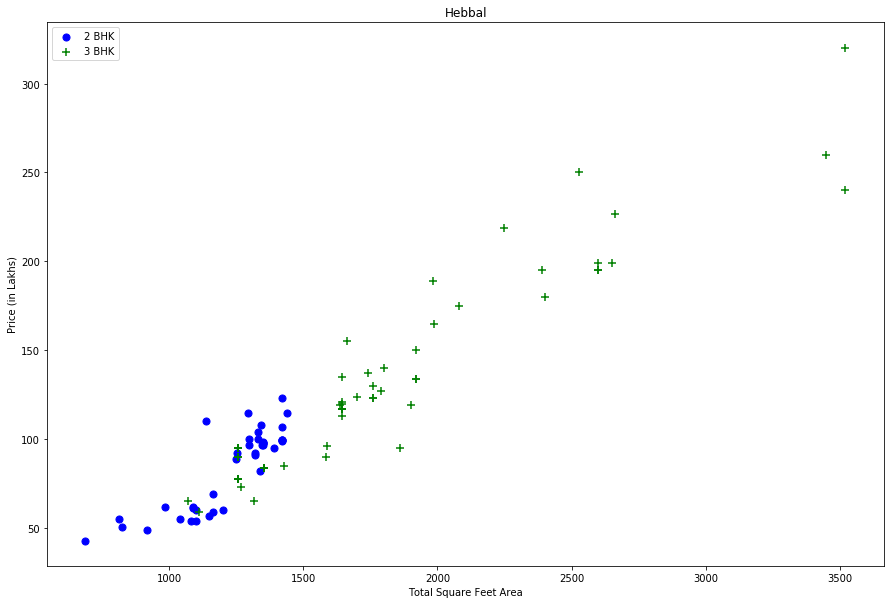

In [48]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    rcP['figure.figsize'] = (15,10)
    plt.scatter(bhk2.new_total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.new_total_sqft, bhk3.price, color='green', marker='+', label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price (in Lakhs)')
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df3, 'Hebbal')

In [49]:

# Here we observe that 3 BHK cost that same as 2 BHK in 'Hebbal' location hence removing such outliers is necessary
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    
    return df.drop(exclude_indices, axis='index')

df4 = remove_bhk_outliers(df3)

In [50]:
df4.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0,15017.543860
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0,11901.840491
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0,12533.333333
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0,10833.333333
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0,11983.805668


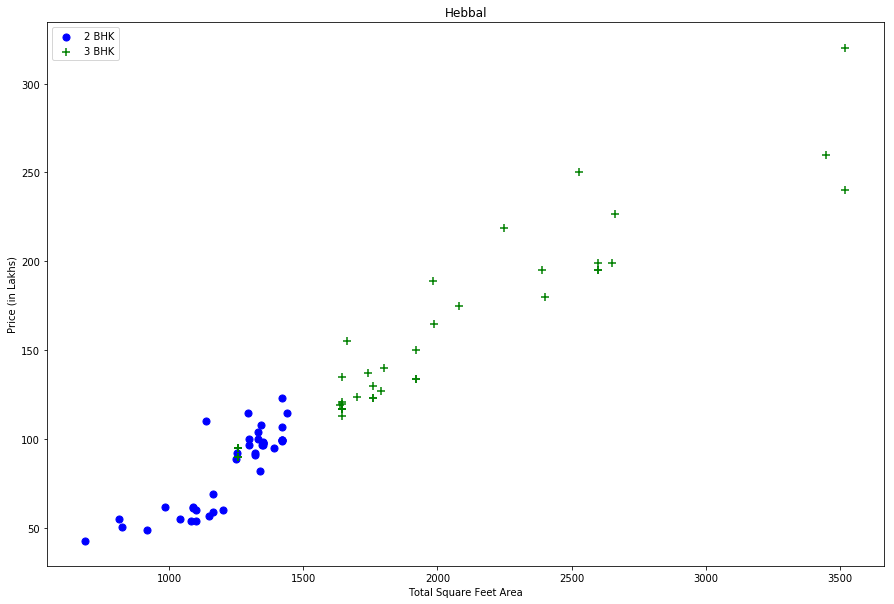

In [51]:
plot_scatter_chart(df4, 'Hebbal')

Text(0,0.5,'Count')

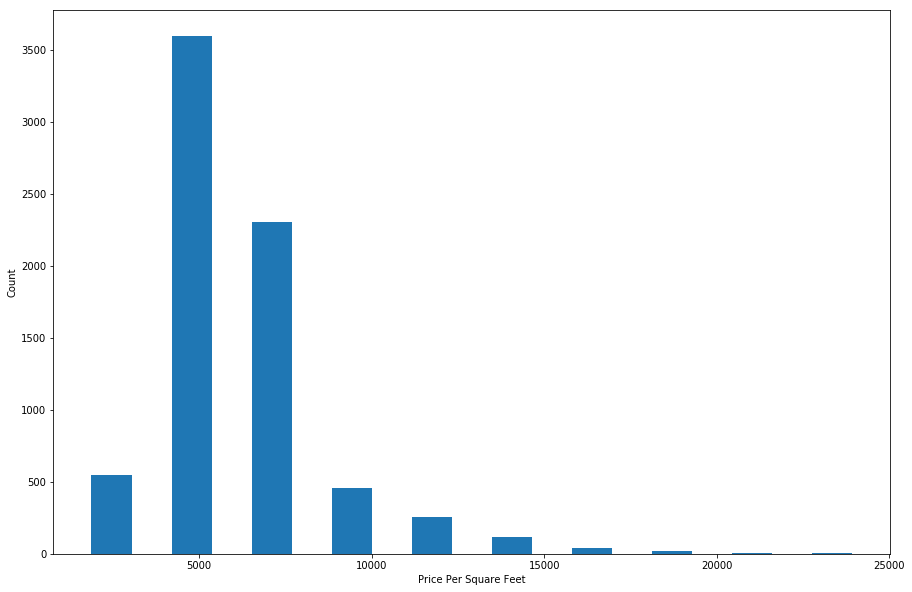

In [52]:
plt.hist(df4.price_per_sqft, rwidth=0.5)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')

In [53]:
# Removing the rows that have 'bath' greater than 'bhk'+2
df5 = df4[df4.bath<(df4.bhk+2)]

In [54]:
df5.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0,15017.543860
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0,11901.840491
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0,12533.333333
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0,10833.333333
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0,11983.805668


## Model Building

In [55]:
# Removing the unnecessary columns (columns that were added only for removing the outliers)
df6 = df5.copy()
df6 = df6.drop('price_per_sqft', axis='columns')

In [56]:
df6.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0


In [57]:
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.location)
df6 = pd.concat([df6,dummy_cols], axis='columns')

In [58]:
df6.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,1st Block Jayanagar,1st Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.availability)
df6 = pd.concat([df6,dummy_cols], axis='columns')

In [60]:

# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.area_type)
df6 = pd.concat([df6,dummy_cols], axis='columns')

In [61]:
df6.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,1st Block Jayanagar,1st Phase JP Nagar,...,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other,Not Ready,Ready To Move,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [62]:
df6.drop(['area_type','availability','location'], axis='columns', inplace=True)
df6.head()

,bath,balcony,price,bhk,new_total_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other,Not Ready,Ready To Move,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,4.0,1.0,428.0,4,2850.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,3.0,2.0,194.0,3,1630.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2.0,3.0,235.0,3,1875.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2.0,0.0,130.0,3,1200.0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,2.0,2.0,148.0,2,1235.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [63]:
df6.shape

(7264, 252)

In [64]:
#splitting the dataset
X = df6.drop('price', axis='columns')
y = df6['price']

In [65]:
X.head()

,bath,balcony,bhk,new_total_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other,Not Ready,Ready To Move,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,4.0,1.0,4,2850.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,3.0,2.0,3,1630.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2.0,3.0,3,1875.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2.0,0.0,3,1200.0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,2.0,2.0,2,1235.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [66]:
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [71]:
# Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [73]:

# Creating Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [74]:
model.score(X_test, y_test)

0.8571225552598866

In [75]:
import pickle

In [76]:
pickle.dump(model, open("Bengaluru_house_price_prediction.pkl",'wb'))